In [98]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, matthews_corrcoef
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

from sklearn.model_selection import StratifiedKFold


In [99]:
train_df = pd.read_csv('train.csv', index_col = 'id')
test_df = pd.read_csv('test.csv', index_col = 'id')
secondary = pd.read_csv('secondary_data.csv', sep = ';')
tertiary = pd.read_csv('one_million_mushrooms.csv', sep = ';')
tertiary_test = pd.read_csv('tertiary_data_2.csv', sep = ';') # ? Intended as test data but could be used for training?

In [100]:
train_df = pd.concat([train_df, secondary, tertiary, tertiary_test], ignore_index=True)

In [101]:
train_df

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,e,8.80,f,s,u,f,a,c,w,4.51,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,p,4.51,x,h,o,f,a,c,n,4.79,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,e,6.94,f,s,b,f,x,c,w,6.85,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,e,3.88,f,y,g,f,s,NaN,g,4.16,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,e,5.85,x,l,w,f,d,NaN,w,3.37,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4735009,p,3.15,o,s,y,f,f,f,f,0.00,...,f,f,f,NaN,NaN,t,f,NaN,d,u
4735010,e,6.19,x,y,n,f,e,c,p,5.39,...,NaN,y,n,NaN,NaN,f,f,NaN,d,u
4735011,e,5.37,o,l,n,f,f,f,f,8.69,...,NaN,NaN,n,NaN,NaN,f,f,g,d,w
4735012,p,3.96,o,s,n,f,f,f,f,0.00,...,f,f,f,NaN,NaN,t,f,NaN,d,a


In [102]:
features = train_df.drop('class', axis = 1).columns.tolist()

In [103]:
features_with_high_null_values = [feature for feature in features if (train_df[feature].isna().sum()/len(train_df) * 100) > 20]
features_with_high_null_values

['cap-surface',
 'gill-spacing',
 'stem-root',
 'stem-surface',
 'veil-type',
 'veil-color',
 'spore-print-color']

In [104]:
categorical_features = train_df[features].select_dtypes(include = 'object').columns.tolist()
numerical_features = list(set(features) - set(categorical_features))

In [105]:
def cleaner(df, cols_to_filter):

    # ? NO DIFFERENCE IN STRATEGY

    # for col in categorical_features:
    #     df.loc[df[col].value_counts(dropna = False)[df[col]].values < 100, col] = np.nan
    #     df[col] = df[col].fillna('missing')
    #     df[col] = df[col].astype('category')
    features_dict = {
        'cap_shape': ['x', 'f', 's', 'b', 'o', 'p', 'c'],
        'cap_surface': ['t', 's', 'y', 'h', 'g', 'd', 'k', 'e', 'i', 'w', 'l'],
        'cap_color': ['n', 'y', 'w', 'g', 'e', 'o', 'p', 'r', 'u', 'b', 'k', 'l'],
        'does_bruise_or_bleed': ['f', 't'],
        'gill_attachment': ['a', 'd', 'x', 'e', 's', 'p', 'f'],
        'gill_spacing': ['c', 'd', 'f'],
        'gill_color': ['w', 'n', 'y', 'p', 'g', 'o', 'k', 'f', 'r', 'e', 'b', 'u'],
        'stem_root': ['b', 's', 'r', 'c', 'f'],
        'stem_surface': ['s', 'y', 'i', 't', 'g', 'k', 'h', 'f'],
        'stem_color': ['w', 'n', 'y', 'g', 'o', 'e', 'u', 'p', 'k', 'r', 'l', 'b', 'f'],
        'veil_type': ['u'],
        'veil_color': ['w', 'y', 'n', 'u', 'k', 'e'],
        'has_ring': ['f', 't'],
        'ring_type': ['f', 'e', 'z', 'l', 'r', 'p', 'g', 'm'],
        'spore_print_color': ['k', 'p', 'w', 'n', 'r', 'u', 'g'],
        'habitat': ['d', 'g', 'l', 'm', 'h', 'w', 'p', 'u'],
        'season': ['a', 'u', 'w', 's']
    }
    
    for classes, cols  in zip(features_dict.keys(), cols_to_filter):
        # df.loc[(~df[cols].isin(features_dict[classes])) & pd.notna(df[cols]), cols] = 'missing'
        df.loc[~df[cols].isin(features_dict[classes]), cols] = "missing"
        df[cols] = df[cols].astype('category')

    return df

In [106]:
def feature_engineering(df):
    df['stem-area'] = df['stem-height'] * df['stem-width']
    return df

In [107]:
train_df = cleaner(train_df, categorical_features)
test_df = cleaner(test_df, categorical_features)

In [108]:
# train_df = feature_engineering(train_df)
# test_df = feature_engineering(test_df)

In [109]:
knn_imputer = KNNImputer(n_neighbors = 3) # KNN imputer uses other numerical features to find values for the missing values

train_df['cap-diameter'] = knn_imputer.fit_transform(train_df[['cap-diameter']]) 
test_df['cap-diameter'] = knn_imputer.fit_transform(test_df[['cap-diameter']])

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4735014 entries, 0 to 4735013
Data columns (total 21 columns):
 #   Column                Dtype   
---  ------                -----   
 0   class                 object  
 1   cap-diameter          float64 
 2   cap-shape             category
 3   cap-surface           category
 4   cap-color             category
 5   does-bruise-or-bleed  category
 6   gill-attachment       category
 7   gill-spacing          category
 8   gill-color            category
 9   stem-height           float64 
 10  stem-width            float64 
 11  stem-root             category
 12  stem-surface          category
 13  stem-color            category
 14  veil-type             category
 15  veil-color            category
 16  has-ring              category
 17  ring-type             category
 18  spore-print-color     category
 19  habitat               category
 20  season                category
dtypes: category(17), float64(3), object(1)
memory usage: 2

In [110]:
from sklearn.preprocessing import LabelEncoder

X = train_df.copy()
y = X.pop('class')

lab_enc = LabelEncoder().fit(y)
y = lab_enc.transform(y)

In [111]:


def model_report(estimator, X, y, cv = 5):
    print('='*80)
    print(f"     Model: {estimator.__class__.__name__}")
    print('='*80)

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 1/cv, shuffle = True, stratify = y, random_state = 42)

    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"F1 Score : {f1.mean():.6f}")
    print(f"MCC Score : {mcc.mean():.6f}")

    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
    plt.title('Confusion Matrix')
    plt.show()

    print()


In [112]:
def model_trainer(model, X, y, n_splits = 5, random_state = 42):
    skfold = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = random_state)
    oof_probs, oof_mccs = [], []
    print('='*80)
    print(f"Training {model.__class__.__name__}")
    print('='*80, end = '\n')

    for fold, (train_idx, test_idx) in enumerate(skfold.split(X, y)):
        X_train, y_train = X.iloc[train_idx, :], y[train_idx]
        X_test, y_test = X.iloc[test_idx, :], y[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mcc = matthews_corrcoef(y_pred, y_test)
        oof_mccs.append(mcc)
        oof_probs.append(model.predict_proba(test_df))

        print(f"--- Fold {fold + 1} MCC Score: {mcc:.6f}")
        print(f"\n---> Mean MCC Score: {np.mean(oof_mccs):.6f} \xb1 {np.std(oof_mccs):.6f}\n\n")
        return oof_probs, oof_mccs

     Model: XGBClassifier
F1 Score : 0.995017
MCC Score : 0.988943


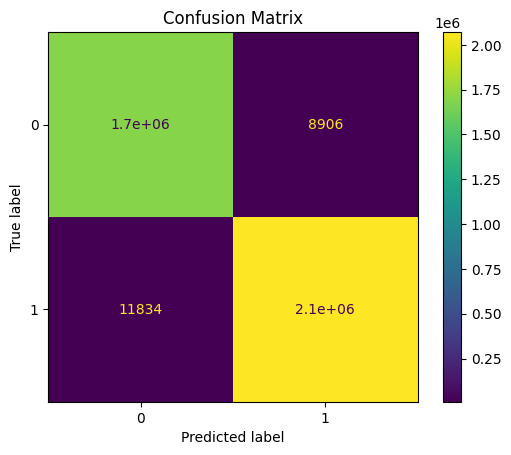

In [113]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(enable_categorical = True, device = 'cuda', tree_method = 'gpu_hist')

model_report(xgb_clf, X, y)

Notes

In [114]:

# * MCC Score : 0.983147
# * MCC Score : 0.983182 ; noise is converted to missing
# * MCC Score : 0.983182 ; no difference in managing missing values
# * MCC Sore : 0.982143 ; leave np.nans and one hot encoding
# * MCC Score : 0.983161 ; leave np.nans
# * MCC Score : 0.983182 ; noise converted to missing ; KNN Imputer
# * MCC Score : 0.983123 ;  noise converted to missing ; KNN Imputer ; tree_method = 'approx'
# * MCC Score : 0.983062 ;  noise converted to missing ; feature engineering added stem-area
# * MCC Score : 0.983526 ; noise converted to missing ; added secondary data
# * MCC Score : 0.987624 ; noise converted to missing ; added secondary data ; added tertiary data
# * MCC Score : 0.988943 ; noise converted to missing ; added secondary data ; added tertiary data ; added tertiary2 data


In [115]:
# from catboost import CatBoostClassifier

# cat_clf = CatBoostClassifier(
#     cat_features = categorical_features,
#     verbose = False,
#     allow_writing_files = False,
#     task_type = "GPU"
# )

# model_report(cat_clf, X, y)

In [116]:
# from lightgbm import LGBMClassifier

# lgb_clf = LGBMClassifier(device = 'gpu', verbosity = -1)

# model_report(lgb_clf, X, y)

In [117]:
xgb_params = {
    'n_estimators': 2407,
    'eta': 0.009462133032592785,
    'gamma': 0.2865859948765318,
    'max_depth': 31,
    'min_child_weight': 47,
    'subsample': 0.6956431754146083,
    'colsample_bytree': 0.3670732604094118,
    'grow_policy': 'lossguide',
    'max_leaves': 73,
    'enable_categorical': True,
    'n_jobs': -1,
    'device': 'cuda',
    'tree_method': 'hist'
} # 0.9844272567086021

cat_params = {
    'iterations': 1041,
    'learning_rate': 0.08777255350163136,
    'depth': 10,
    'l2_leaf_reg': 0.1259643500248322,
    'bootstrap_type': 'Bayesian',
    'random_strength': 4.276181166674371e-08,
    'bagging_temperature': 0.35995482350907326,
    'od_type': 'Iter',
    'od_wait': 39,
    "verbose": False,
    "allow_writing_files": False,
    "task_type": 'GPU',
    "cat_features": categorical_features
} # 0.9841773055825763

lgb_params = {
    'n_estimators': 2500,
    'random_state':42,
    'max_bin':1024,
    'colsample_bytree':0.6,
    'reg_lambda': 80,
    # 'device': 'gpu',
    'verbosity': -1
}

In [118]:
# oof_probs = {}

# oof_probs['lgb'], _ = model_trainer(LGBMClassifier(**lgb_params), X, y, random_state = 101)

In [119]:
# oof_preds = {}
# for model in oof_probs.keys():
#     oof_preds[model] = np.argmax(np.mean(oof_probs[model], axis = 0), axis = 1)

In [120]:
# oof_preds['lgb']

In [121]:
# preds = oof_preds['lgb']

In [122]:
# sub = pd.read_csv('sample_submission.csv')

In [123]:
# sub['class'] = lab_enc.inverse_transform(preds)

In [124]:
# sub.to_csv('Example_LGBM.csv', index = False)